In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from fenics import *

from algorithms.matrix_free_rsvd import MatrixFreeRSVD, get_approximate_W, tikhonov_solver
from utils.mesh_utils import get_square_f
from utils.colors import C2, C3, C5, CMAP
from scipy.sparse import diags

import importlib
import algorithms.weighted_low_rank_solver
importlib.reload(algorithms.weighted_low_rank_solver)
from algorithms.weighted_low_rank_solver import WeightedLowRankSolver

In [3]:
def plot_records(solver: WeightedLowRankSolver, title=None, xmin=0, ylim=None):
    fig, axes = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
    ax1, ax2, ax3 = axes

    grads_P = solver.grads_P[xmin:]
    grads_Q = solver.grads_Q[xmin:]
    X_rel   = solver.X_rel[xmin // 25:]
    residuals  = solver.residuals[xmin:]
    errors = solver.errors[xmin:]

    # x-axis for dX (every 25th point)
    nx = len(X_rel)
    xx = np.arange(0, nx * 25, 25) + xmin

    # x-axis for others
    no = len(grads_P)
    xo = np.arange(0, no) + xmin
    
    #ax1.semilogy(xo, grads_P,   label='$\\nabla_P X$', c=C2[0], lw=2)
    #ax1.semilogy(xo, grads_Q,   label='$\\nabla_Q X$', c=C2[1], lw=2, ls='--')
    ax1.semilogy(xo, errors,    label='Error',         c=C2[0], lw=2)
    ax2.semilogy(xx, X_rel,     label='Relative $dX$', c=C2[0], lw=2)
    ax3.semilogy(xo, residuals, label='Residual',      c=C2[0], lw=2)

    # Mark minimum error and residual
    idxmin_r = np.argmin(residuals)
    idxmin_e = np.argmin(errors)
    ax1.semilogy(xo[idxmin_e], errors[idxmin_e], marker='o', c='r', label=f'Min ({xo[idxmin_e]})')
    ax3.semilogy(xo[idxmin_r], residuals[idxmin_r], marker='o', c='r', label=f'Min ({xo[idxmin_r]})')

    for ax in axes:
        ax.legend()
        ax.grid(alpha=0.5)
        ax.set_xticks(np.arange(0, no, no // 8) + xmin)
        ax.set_ylim(ylim)
    
    ax1.set_title(title)
    ax3.set_xlabel("Iteration")
    plt.tight_layout()
    plt.show()


In [4]:
mesh = UnitSquareMesh(64, 64)
V_h = FunctionSpace(mesh, 'CG', 1)

rsvd = MatrixFreeRSVD(V_h)
x0, y0, width, height = 0.1, 0.7, 0.15, 0.15
f = get_square_f(V_h, x0, y0, w=width, h=height)
#f = get_disk_f(V_h, x0, y0, r=0.1)
x = f.vector().get_local()
y = rsvd.apply_K(x)

In [5]:
k = 25
seed = None
lambda_ = 1e-4

# Approximate SVD K = U S V^T and weights W
Uk, Sk, VkT = rsvd.mf_rsvd(k=k, seed=seed)
w = get_approximate_W(VkT.T, rsvd.M_dx)
x_tikhonov = tikhonov_solver(
    rsvd=rsvd, W_diag=w, y=y, lambda_=lambda_)

f_tikhonov = Function(V_h)
f_tikhonov.vector()[:] = x_tikhonov

[##############################] 10000/10000 (dX=1.9e-04)



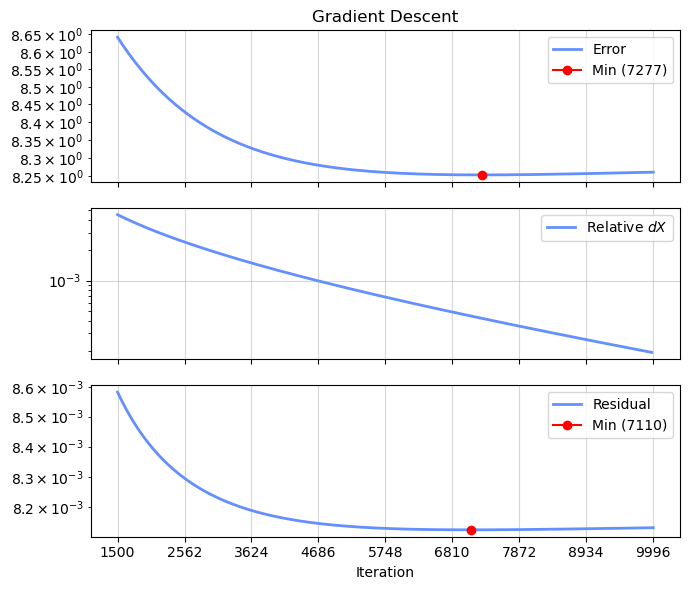

In [6]:
# Low-rank solution
solver = WeightedLowRankSolver(
    V_h=V_h, M_dx=rsvd.M_dx, M_ds=rsvd.M_ds,
    U=Uk, S=Sk, VT=VkT, x_true=x)

# Low-rank weighted tikhonov solution
f_low_rank = solver.solve(y,
    r_s=1,
    w=w,
    alpha=500,     # step size
    lambda_=lambda_,  # regularization param
    initial_matrices='random',
    max_iter=10000,
    seed=15
)
#plot(f_low_rank)
plot_records(solver, title='Gradient Descent', xmin=1500)

[##############################] 5000/5000 (dX=8.3e-03)

Returning lowest error solution (iteration 2922)


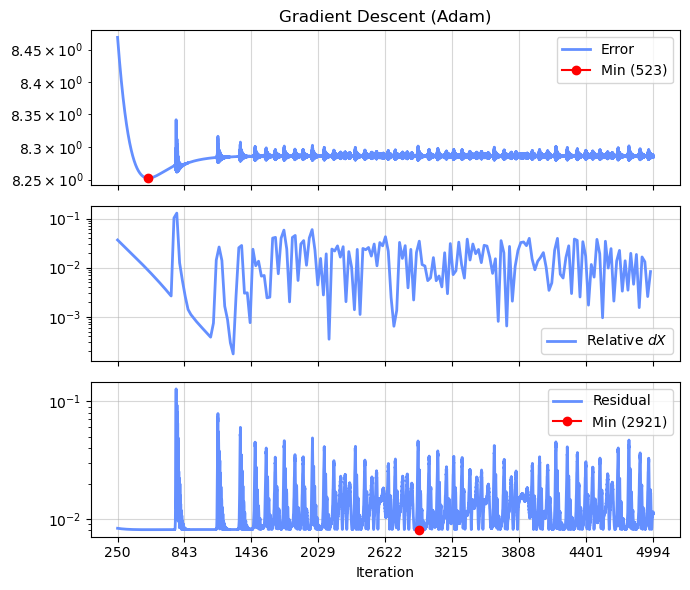

In [7]:
f_adam = solver.solve_adam(y,
    r_s=1,
    w=w,
    lambda_=lambda_,  # regularization param
    seed=seed,
    tol=1e-4,
)
#plot(f_adam)
plot_records(solver, title='Gradient Descent (Adam)', xmin=250)

[######                        ] 1100/5000 (dX=9.6e-05)
Converged at iteration 1100
Returning lowest error solution (iteration 1100)


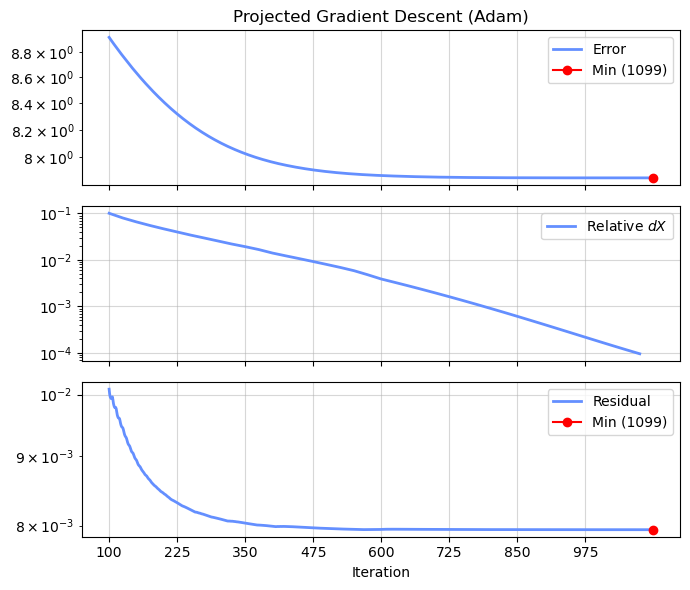

In [7]:
f_adam_projected = solver.solve_adam(y,
    r_s=1,
    w=w,
    lambda_=lambda_,  # regularization param
    seed=seed,
    tol=1e-4,
    projection=True,
    sol_criteria='error'
)
plot_records(solver, title='Projected Gradient Descent (Adam)', xmin=100)

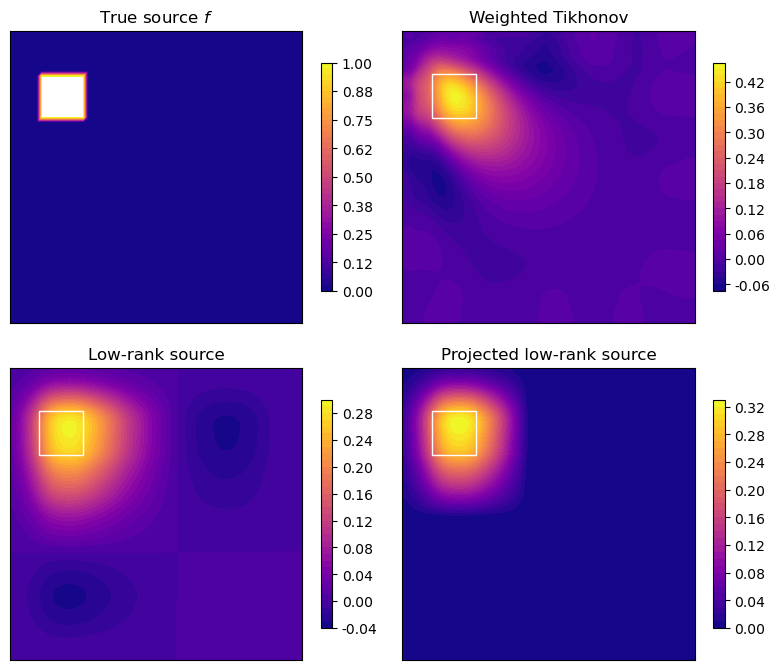

In [21]:
def plot_solutions(fs, ts):
    fig, axes = plt.subplots(2, 2, figsize=(8, 7))
    axes = axes.flatten()

    for i, (ax, fi, ti) in enumerate(zip(axes, fs, ts)):
        plt.sca(ax)

        # Plot f
        p = plot(fi, cmap=CMAP)

        fig.colorbar(p, ax=ax, format="%.2f", shrink=0.71)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(ti)
 
        # Plot square
        if i != 0:
            square = patches.Rectangle((x0, y0), width, height, edgecolor='white', facecolor='none')
            ax.add_patch(square)

    plt.tight_layout()
    plt.show()

plot_solutions(
    fs=[f, f_tikhonov, f_adam, f_adam_projected],
    ts=["True source $f$",
        "Weighted Tikhonov",
        "Low-rank source",
        "Projected low-rank source"]
)

[##############################] 2500/2500 (dX=1.7e-02)

Returning lowest error solution (iteration 1526)


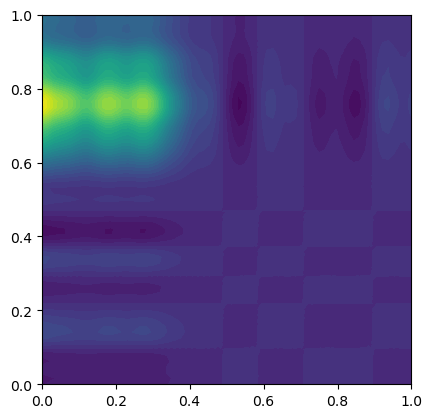

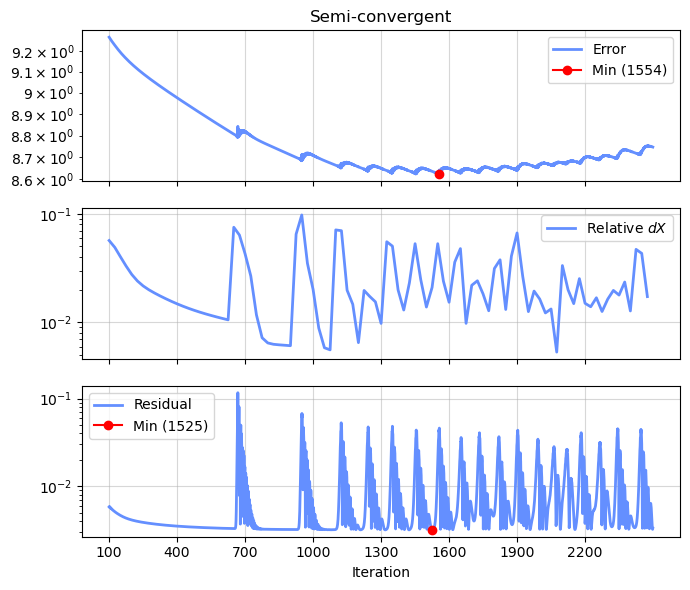

In [16]:
# Low-rank weighted tikhonov solution
f_semi = solver.solve_semi(y,
    r_s=1,
    w=w,
    seed=seed,
    max_iter=2500,
)
plot(f_semi)
plot_records(solver, title='Semi-convergent', xmin=100)

[##############################] 2000/2000 (dX=7.4e-03)

Returning lowest error solution (iteration 492)


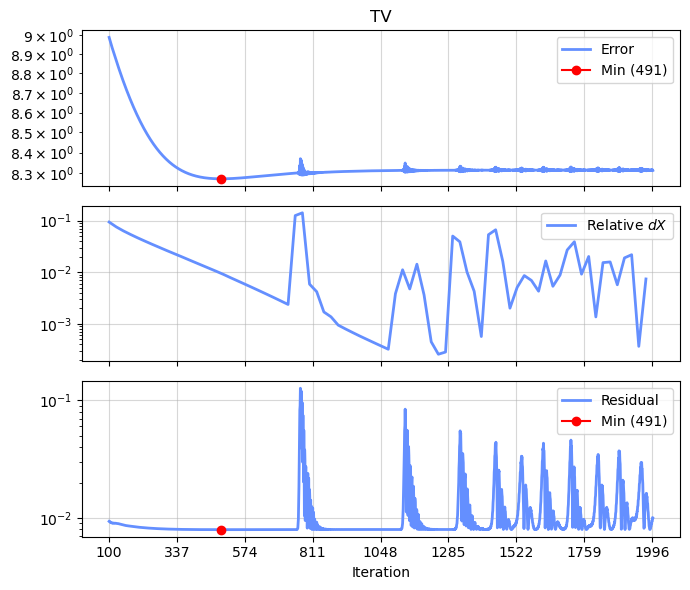

In [17]:
# Low-rank weighted tikhonov solution
f_TV = solver.solve_TV(y,
    r_s=1,
    w=w,
    lambda_=1e-4,  # regularization param
    max_iter=2000,
    beta=5e-8,
    seed=seed,
    projection=False
)
plot_records(solver, title='TV', xmin=100)

[################              ] 1100/2000 (dX=9.4e-05)
Converged at iteration 1100
Returning lowest error solution (iteration 1100)


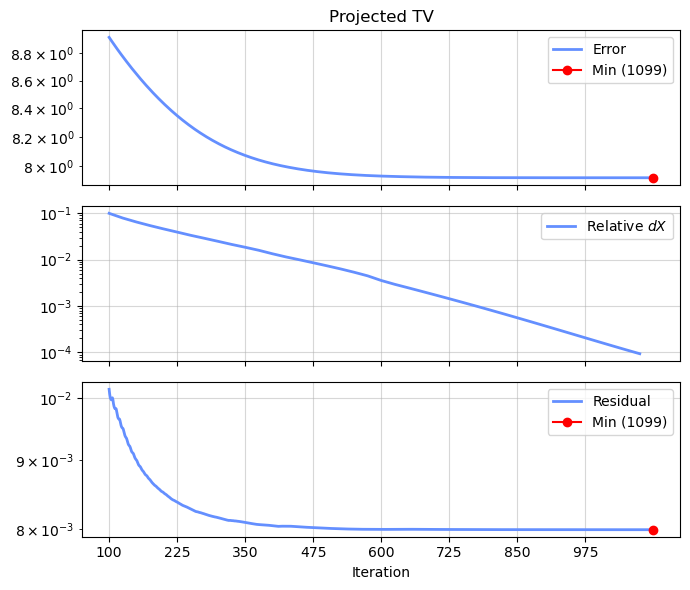

In [18]:
f_TV_projected = solver.solve_TV(y,
    r_s=1,
    w=w,
    lambda_=1e-4,  # regularization param
    max_iter=2000,
    beta=5e-8,
    seed=seed,
    projection=True
)
plot_records(solver, title='Projected TV', xmin=100)

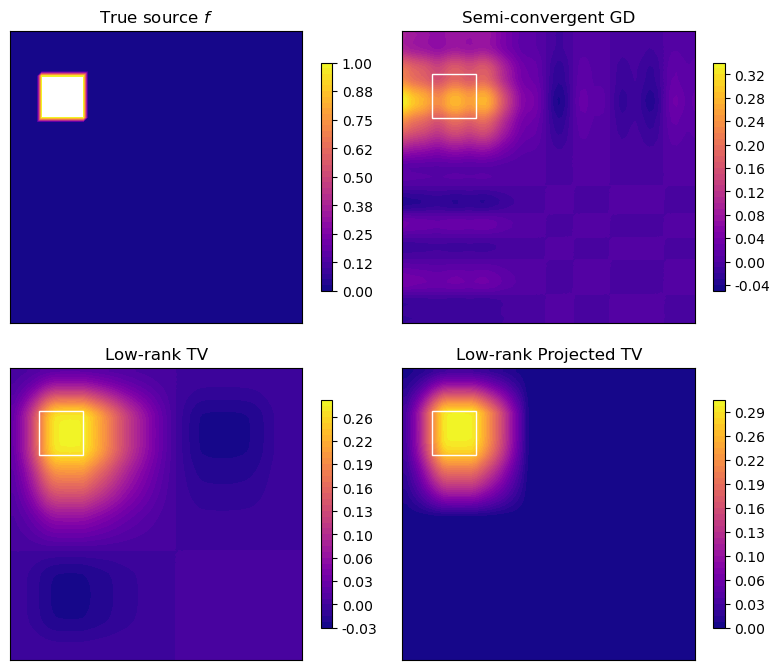

In [19]:
plot_solutions(
    fs=[f, f_semi, f_TV, f_TV_projected],
    ts=["True source $f$",
        "Semi-convergent GD",
        "Low-rank TV",
        "Low-rank Projected TV"]
)